# Large project 1.5 - Variational Inference

[Paper: Blei, David M., and Michael I. Jordan. ”Variational methods for the Dirichlet process.” Proceedings of the twenty-first international conference on Machine learning. 2004.](https://people.eecs.berkeley.edu/~jordan/papers/vdp-icml.pdf)

## Tasks for [Blei and Jordan, 2004]:
1. Implement the VI algorithm presented in the paper from scratch.
2. Generate synthetic data in the same way as it has been generated in the paper.
3. Find robot data used in the paper.
4. Try to replicate the VI results for both the simulated and robot data.
5. Comment on whether the results of the paper are reproducible in your experiments.
6. Discuss the original paper in terms of approach, methodology, and conclusions.

Regarding the tasks provided concerning the study of the paper, we will organize this notebook according to the following scheme :
1. Data loading (mixture model sampling and robot data),
2. Implementing the VI algorithm for DP mixture model,
3. Testing the algorithm on the data.

Across this notebook, we will use the notations defined in the research paper. The formula used are given in the paper and some of them are detailed in the project report.

We start by importing the relevant libraries :

In [20]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch.distributions import Beta, Categorical, Multinomial, MultivariateNormal
from torch.nn import functional as F
from scipy.special import digamma
from tqdm import tqdm
from scipy.stats import multivariate_normal as mvn
from scipy.stats import beta as beta
from scipy.stats import gamma as gamma
from scipy.stats import multinomial as multinomial

SEED = 80

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# print torch version
print(torch.__version__)
print(np.__version__)

2.1.2+cpu
1.26.3


# 1. Data loading

## 1.1. Simulated mixture model sampling

The distribution $G_0$ that governs the sampling of the $\eta^*$ is a Gaussian with mean $(0, 0)$ and covariance matrix $\text{Diag}(10, 10)$. <br>
Then, $\forall n \in \mathbb{N}$, $\eta_n$ is sampled following the Dirichlet process given in the paper and the data $X_n$ is sampled according to a Gaussian law with mean $\eta_n$ and fixed covariance matrix $\text{Diag}(0.3, 0.3)$. Those choices are arbitrary.

In [21]:
# Generating datapoints from a Gaussian DP
N = 100
def sample_DP_Gaussian(N, alpha) :
    X = np.zeros((N, 2))
    star_etas = {} # keys : values of eta* ; values : number of time they have been sampled

    # covariance is fixed, so eta corresponds to the mean of the gaussian law

    eta_mean = np.array([0, 0])
    eta_var = 10
    X_covariance_matrix = 0.3*np.identity(2)
    eta_covariance_matrix = eta_var*np.identity(2)

    # initialization of the first value of eta*
    eta = np.random.multivariate_normal(eta_mean, eta_covariance_matrix)
    eta_i = tuple(eta)
    star_etas[eta_i] = 1


    for i in range (1, N) :
        eta = np.random.multivariate_normal(eta_mean, eta_covariance_matrix)
        keys = list(star_etas.keys())
        values = list(star_etas.values())

        probas = [values[i]/(N-1+alpha) for i in range(len(values))]
        probas.append(alpha/(N-1+alpha))

        # sampling from the categorical distribution an index corresponding to the value of eta*
        idx = Categorical(torch.tensor(probas)).sample().item()

        if (idx == len(probas)-1) : # a new value has been sampled
            eta_i = tuple(eta)
            star_etas[eta_i] = 1

        else : # one of the previous eta* has been sampled
            eta_i = keys[idx]
            star_etas[eta_i] += 1

        X[i] = np.random.multivariate_normal(eta_i, X_covariance_matrix)

    return torch.tensor(X), keys, eta_mean, eta_var

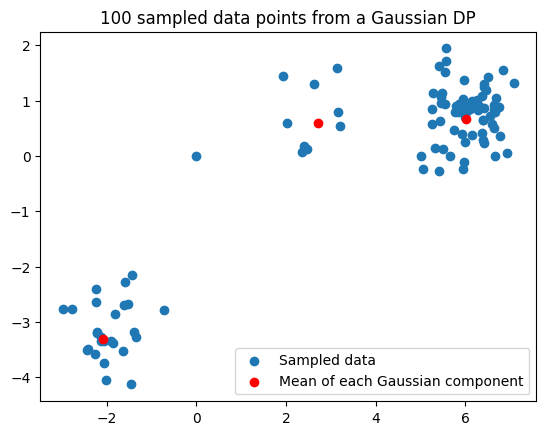

In [22]:
# sampling the data points
X, keys, eta_mean, eta_var = sample_DP_Gaussian(100, 0.6)

# plotting the data points
plt.figure()
plt.scatter(X[:,0], X[:,1])
# plot values of eta
for i in range(len(keys)) :
    plt.scatter(keys[i][0], keys[i][1], color='red')
# add legend for red points
plt.legend(['Sampled data', 'Mean of each Gaussian component'])
plt.title("100 sampled data points from a Gaussian DP")
plt.show()

## 1.2. Robot Data

Let's load the Robot data mentioned on the paper. THen, we will test the VI algorithm on this dataset.

In [23]:
"""def getRobotData():
  # Using pumadyn data which has 8 inputs per data point, medium noise and high non linearity

  # ----------- IGNORE -----------------------------------------
  # from google.colab import drive
  # drive.mount('/content/drive/')
  # !--NotebookApp.iopub_data_rate_limit=1.0e10
  # reading from the file
  # file = open("/content/drive/MyDrive/Colab Notebooks/pumadyn-8nm/Dataset.data", "r")
  # -------------------------------------------------------------

  # Read data and turn into 2D array
  file = open("Dataset.data", "r")
  rows = file.read().split("\n")
  file.close()
  rows = [row for row in rows if row]
  data = [list(map(float, row.split())) for row in rows]

  # Shuffle and split into training and test data sets of the same size as used in Blei Jordan
  random.shuffle(data)
  training_data = np.array(data[:7000])
  test_data = np.array(data[7000:7250])

  training_X = training_data[:, :-1]  # All rows, all columns except the last one
  training_Y = training_data[:, -1]   # All rows, only the last column
  test_X = test_data[:, :-1]  # All rows, all columns except the last one
  test_Y = test_data[:, -1]   # All rows, only the last column

  return torch.tensor(training_X), torch.tensor(training_Y), torch.tensor(test_X), torch.tensor(test_Y)"""

'def getRobotData():\n  # Using pumadyn data which has 8 inputs per data point, medium noise and high non linearity\n\n  # ----------- IGNORE -----------------------------------------\n  # from google.colab import drive\n  # drive.mount(\'/content/drive/\')\n  # !--NotebookApp.iopub_data_rate_limit=1.0e10\n  # reading from the file\n  # file = open("/content/drive/MyDrive/Colab Notebooks/pumadyn-8nm/Dataset.data", "r")\n  # -------------------------------------------------------------\n\n  # Read data and turn into 2D array\n  file = open("Dataset.data", "r")\n  rows = file.read().split("\n")\n  file.close()\n  rows = [row for row in rows if row]\n  data = [list(map(float, row.split())) for row in rows]\n\n  # Shuffle and split into training and test data sets of the same size as used in Blei Jordan\n  random.shuffle(data)\n  training_data = np.array(data[:7000])\n  test_data = np.array(data[7000:7250])\n\n  training_X = training_data[:, :-1]  # All rows, all columns except the last on

# 2. Implementing the variational inference algorithm for DP mixture models

All the notations are the ones described in the paper, as well as the formula implemented. This implementation works regardless the dimension of the data. We needed such an asset as the sampled data will be of dimension 2 and the robot data of dimension 8.

In [24]:
class VariationalInferenceDirichletProcessMixtureModel:
    def __init__(self, data, K, alpha, lmbda):
        
        # data parameters
        self.dim = data.shape[1]
        self.N = data.shape[0]
        self.x = data

        # hyperparameters
        self.K = K
        self.alpha = alpha
        self.lmbda = lmbda

        # variatonal parameters
        self.z = torch.zeros(self.N)
        self.etas = torch.zeros(self.K)

        self.phi = torch.zeros(self.N, self.K, dtype=torch.float64)
        self.phis = []

        self.gamma = torch.zeros(self.K, 2)
        self.gamma[-1] = torch.tensor([1, 1]) # V_K is constant equal to 1
        self.gammas = []

        self.tau = torch.zeros(self.K, self.dim + 1, dtype=torch.float64)
        self.taus = []

        # elbo list
        self.elbo = []

    # Expectation of the entropy of Z, V and eta_star wrt to the variatonal distribution
    def E_Z_V_eta(self):
        # sum of eta_star entropies
        eta_star_entropy = np.sum([MultivariateNormal(self.tau[i, :self.dim] / self.tau[i, self.dim], (1/self.tau[i, self.dim]) * np.identity(self.dim)).entropy() for i in range(self.K)])
        # sum of V entropies
        V_entropy = np.sum([Beta(self.gamma[i, 0], self.gamma[i, 1]).entropy() for i in range(self.K)])
        # sum of Z entropies
        Z_entropy = np.sum([Multinomial(self.N, self.phi[i, :]).entropy() for i in range(self.N)])

        return Z_entropy + V_entropy + eta_star_entropy

    # Function that updates the gamma parameters
    def update_gamma(self):
        for i in range(self.K-1):
            self.gamma[i,0] = 1 + torch.sum(self.phi[:,i])
            self.gamma[i,1] = self.alpha + torch.sum(self.phi[:,i+1:])
    
    # Function that updates the tau parameters
    def update_tau(self):
        for i in range (self.K):
            self.tau[i,:self.dim] = self.lmbda[:self.dim] + torch.sum(torch.stack([self.phi[n,i] * self.x[n] for n in range(self.N)]), dim = 0, keepdim=True)
            self.tau[i, self.dim] = self.lmbda[self.dim] + torch.sum(self.phi[:,i])

    # Function that updates the phi parameters
    def update_phi(self):
        E_a_eta = (2 + torch.norm(self.lmbda[:-1])**2)/(2 * self.lmbda[self.dim])
        sum_E_log_one_minus_V_s = torch.tensor([np.sum([digamma(self.gamma[j, 1]) - digamma(
                        self.gamma[j, 0] + self.gamma[j, 1]) for j in range(k+1, self.K)]) for k in range(self.K)])
        
        E_log_V_i_s = torch.tensor([digamma(self.gamma[k,0]) - digamma(self.gamma[k,0] + self.gamma[k,1]) for k in range(self.K)])

        self.phi= torch.exp(E_log_V_i_s + (1/self.tau[:, self.dim]) *torch.matmul(self.x, self.tau[:,:-1].T) - E_a_eta - sum_E_log_one_minus_V_s)
    
        self.phi = self.phi / torch.sum(self.phi, dim=1).view(-1,1)

    # Function that trains the model
    def train(self, max_iter=10):

        # Initializing
        for n in range(self.N):
            self.phi[n,:] = torch.ones(self.K) / self.K
        self.update_gamma()
        self.update_tau()

        expect_z_v_eta = self.E_Z_V_eta()
        self.elbo.append(- expect_z_v_eta)

        for _ in tqdm(range(max_iter)):

            # updating parameters
            self.update_phi()
            self.update_gamma()
            self.update_tau()

            # saving parameters
            self.gammas.append(self.gamma.clone())
            self.taus.append(self.tau.clone())
            self.phis.append(self.phi.clone())

            # updating elbo
            expect_z_v_eta = self.E_Z_V_eta()
            self.elbo.append(- expect_z_v_eta)

    # Function that returns the parameters
    def predict(self):
        return self.elbo, self.gammas, self.taus, self.phis

    # Function that returns the elbo
    def get_elbo(self):
        return self.elbo

# 3. Applying the variational inference algorithm

## 3.1. On the sampled mixture model

$\lambda$, $\alpha$ and data covariance matrix are hyperparameters that need to be fixed by the programmer. The can be better approximated using GridSearch for instance. Here, we will just set a value that fits the sampled data, as we know how it is sampled. Let's see later for the robot data

In [25]:
# adapting parameters wrt the paper notations
lambda_1 = eta_mean / eta_var
lambda_2 = 1 / eta_var
lmbda = torch.tensor(lambda_1.tolist() + [lambda_2])

# training the model
K = 20
alpha = 1.5
n_iter = 20
model = VariationalInferenceDirichletProcessMixtureModel(X, K, alpha, lmbda)
model.train(n_iter)
elbo, gamma_list, tau_list, phi_list = model.predict()


100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


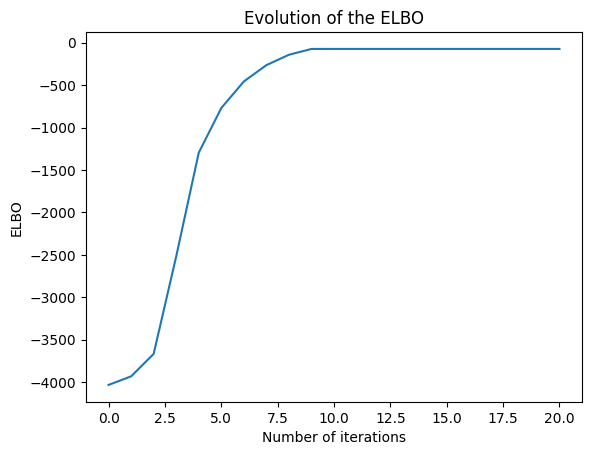

In [26]:
# plotting the evolution of the ELBO
plt.figure()
plt.plot(elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.title("Evolution of the ELBO")
plt.show()


In [27]:
# function that computes the expectation of each theta_i, the parameters of the law of Z
def get_E_theta(gamma, i) :
    E_theta_i = 1
    for j in range (i-1) :
        E_theta_i *= (1 - gamma[j,0]/gamma[j,1])
    E_theta_i *= gamma[i,0]/gamma[i,1]
    return E_theta_i

The last step is to compute the variatonal distribution and to display its contour plot to compare it to the sampled dataset.

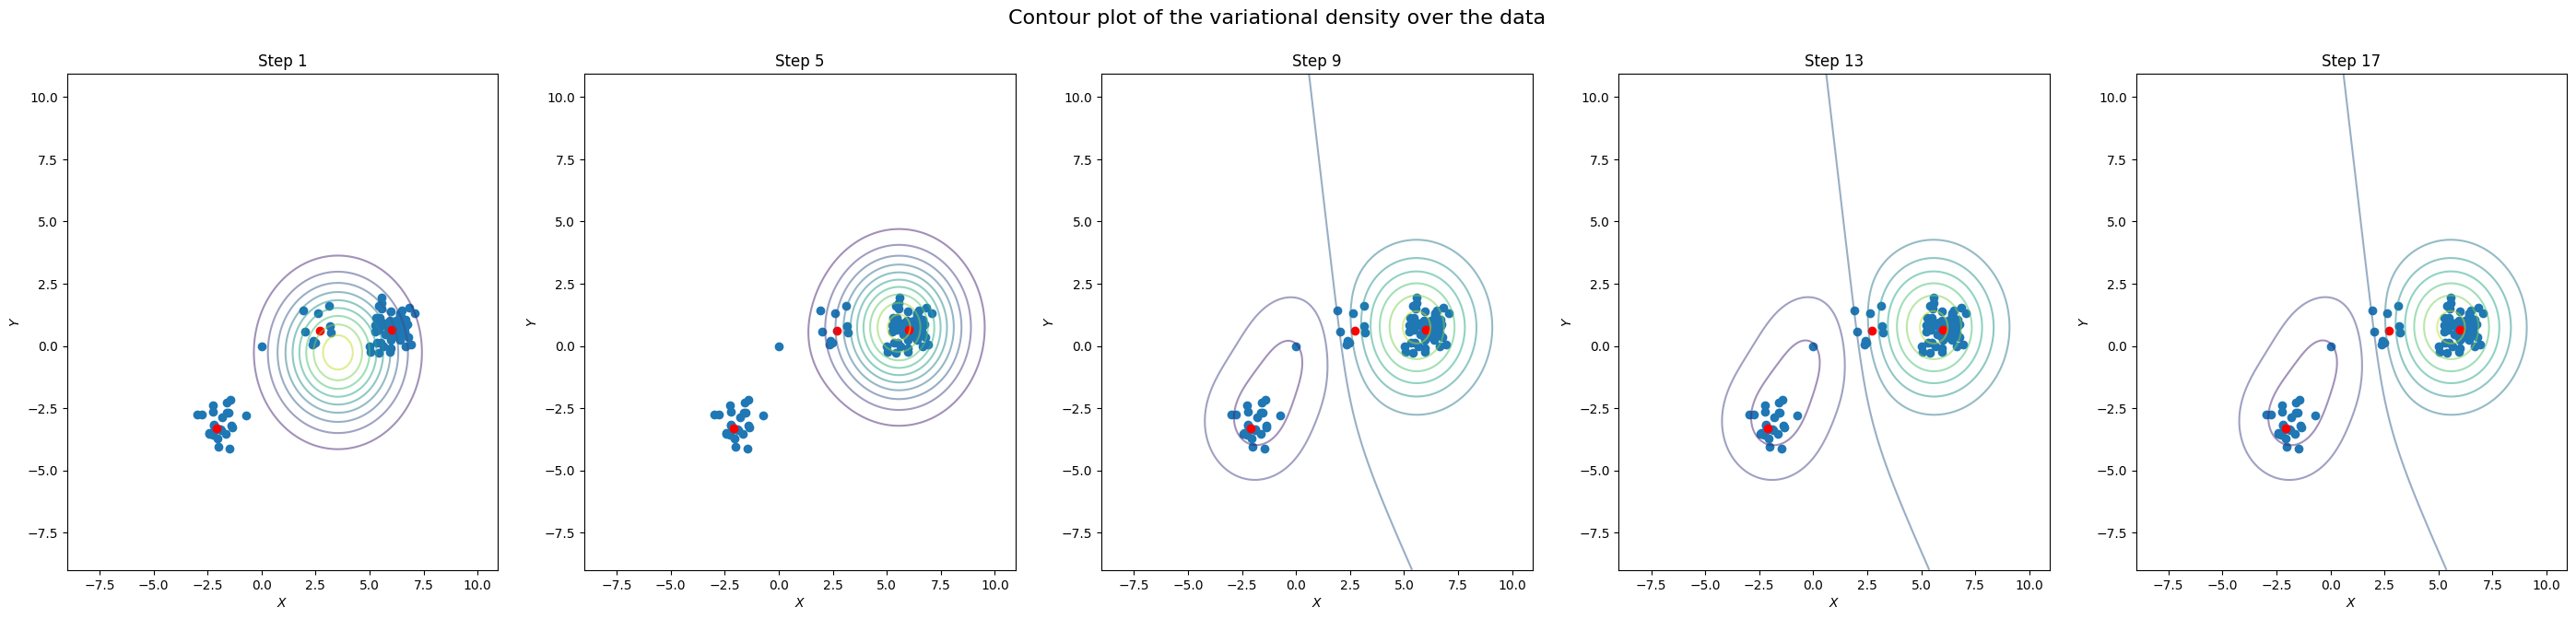

In [28]:
var_X = 0.3
plot_rat = 4
n_plot = n_iter//plot_rat
X_covariance_matrix = 0.3*np.identity(2)
fig, axs = plt.subplots(1, n_plot, figsize=(7*n_plot, 7))

fig.suptitle(
    'Contour plot of the variational density over the data', fontsize=16)

# plot values of sampled eta
for j in range (n_plot) :
    axs[j].set_title('Step ' + str(plot_rat*j+1))
    axs[j].scatter(X[:,0], X[:,1])
    axs[j].set_xlabel(r'$X$')
    axs[j].set_ylabel(r'$Y$')
    # plot values of sampled eta
    for i in range(len(keys)) :
        axs[j].scatter(keys[i][0], keys[i][1], color='red')

# plotting the contour plots
x, y = np.mgrid[-9:11:.05, -9:11:.05]
pos = np.dstack((x, y))


for j in range(n_plot) :
    gamma = gamma_list[plot_rat*j]
    tau = tau_list[plot_rat*j]
    phi = phi_list[plot_rat*j]

    variational_density = 0
    for i in range(K) :
        variational_density += get_E_theta(gamma,i) * mvn.pdf(pos, tau[i,:2] / tau[i,2], (1/var_X) * np.identity(2))
    axs[j].contour(x, y, variational_density,
                   levels=10, cmap='viridis', alpha=0.5)

plt.show()

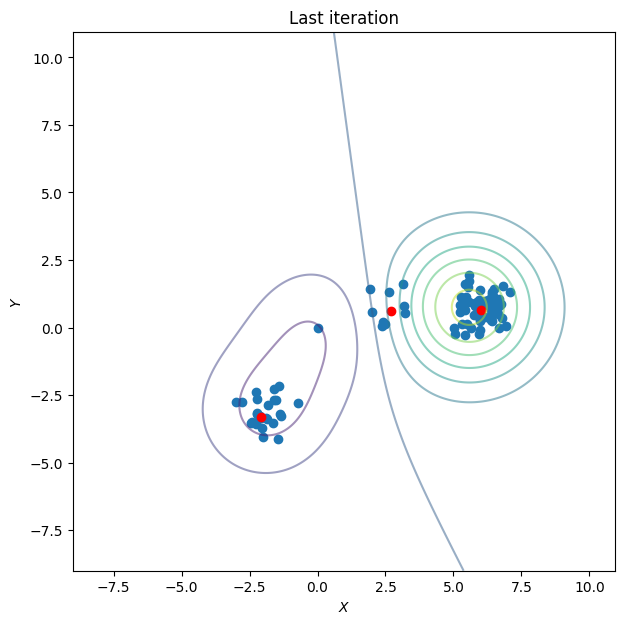

In [29]:
# plotting last iteration
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
# plot values of sampled eta
for i in range(len(keys)) :
    plt.scatter(keys[i][0], keys[i][1], color='red')

# plotting the contour plots
x, y = np.mgrid[-9:11:.05, -9:11:.05]
pos = np.dstack((x, y))

gamma = gamma_list[-1]
tau = tau_list[-1]
phi = phi_list[-1]

variational_density = 0
for i in range(K) :
    variational_density += get_E_theta(gamma,i) * mvn.pdf(pos, tau[i,:2] / tau[i,2], (1/var_X) * np.identity(2))
# normalizing the density
plt.contour(x, y, variational_density, levels=10, cmap='viridis', alpha=0.5)

plt.title("Last iteration")
plt.show()

## 3.2. Held-out likelihood
Let's start by adapting the sampling to the N-dimension case

In [30]:
def sample_DP_MVN_Gaussian(N, alpha, dimension):
    X = np.zeros((N, dimension))
    star_etas = {} # keys : values of eta* ; values : number of time they have been sampled

    # covariance is fixed, so eta corresponds to the mean of the gaussian law

    eta_mean = np.zeros(dimension)
    eta_var = 10
    X_covariance_matrix = 0.3*np.identity(dimension)
    eta_covariance_matrix = eta_var*np.identity(dimension)

    # initialization of the first value of eta*
    eta = np.random.multivariate_normal(eta_mean, eta_covariance_matrix)
    eta_i = tuple(eta)
    star_etas[eta_i] = 1


    for i in range (1, N) :
        eta = np.random.multivariate_normal(eta_mean, eta_covariance_matrix)
        keys = list(star_etas.keys())
        values = list(star_etas.values())

        probas = [values[i]/(N-1+alpha) for i in range(len(values))]
        probas.append(alpha/(N-1+alpha))

        # sampling from the categorical distribution an index corresponding to the value of eta*
        idx = Categorical(torch.tensor(probas)).sample().item()

        if (idx == len(probas)-1) : # a new value has been sampled
            eta_i = tuple(eta)
            star_etas[eta_i] = 1

        else : # one of the previous eta* has been sampled
            eta_i = keys[idx]
            star_etas[eta_i] += 1

        X[i] = np.random.multivariate_normal(eta_i, X_covariance_matrix)

    return torch.tensor(X), keys, eta_mean, eta_var


In [31]:
def get_held_out_likelihood(X_test, dim, gamma_list, tau_list, phi_list) :
    global K, var_X
    gamma = gamma_list[-1]
    tau = tau_list[-1]

    # Compute the log-likelihood for each test data point
    log_likelihoods = []
    for i in range(X_test.shape[0]):
        # Compute the log-likelihood of the data point using the trained model
        likelihood = 0
        for j in range(K):
            likelihood += get_E_theta(gamma,j) * mvn.pdf(X_test[i], tau[j,:dim] / tau[j,dim], (1/var_X) * np.identity(dim))
        if (likelihood > 0) :
            log_likelihoods.append(np.log(likelihood))

    # Compute the held-out likelihood as the average of the log-likelihoods
    held_out_likelihood = np.mean(log_likelihoods)

    return held_out_likelihood


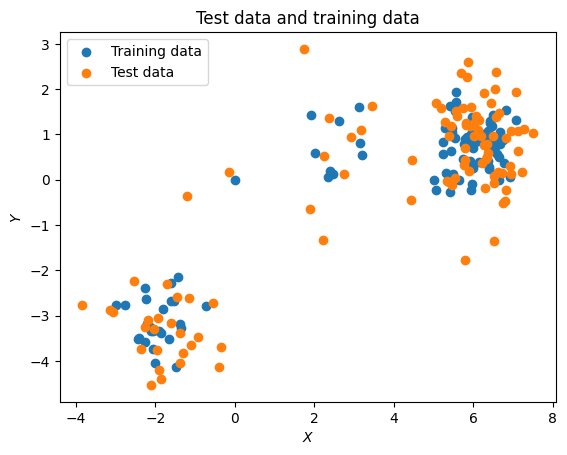

In [39]:
# Test data is training data to which noise is added
X_test = X + np.random.normal(0, 2*var_X, X.shape)

"""# Shuffle, keep half of it and add new points form the same distribution
random.shuffle(test_X)

test_X = test_X[:50]
test_X = torch.cat((test_X, sample_DP_MVN_Gaussian(50, alpha, 2)[0]), 0)"""


# Plot test_X and X on the saime graph
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.scatter(X_test[:,0], X_test[:,1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title("Test data and training data")
plt.legend(['Training data', 'Test data'])
plt.show()

In [33]:
# Compute the held-out likelihood
held_out_likelihood = get_held_out_likelihood(X_test, 2, gamma_list, tau_list, phi_list)
print(held_out_likelihood)


-2.4298766


In [34]:
def training_mv_models(dim):
    # sampling the data points
    X, keys, eta_mean, eta_var = sample_DP_MVN_Gaussian(100, 0.6, dim)

    # adapting parameters wrt the paper notations
    lambda_1 = eta_mean / eta_var
    lambda_2 = 1 / eta_var
    lmbda = torch.tensor(lambda_1.tolist() + [lambda_2])

    # training the model
    K = 20
    alpha = 1.5
    n_iter = 30
    model = VariationalInferenceDirichletProcessMixtureModel(X, K, alpha, lmbda)
    model.train(n_iter)
    elbo, gamma_list, tau_list, phi_list = model.predict()

    """ 
    # plotting the evolution of the ELBO
    plt.figure()
    plt.plot(elbo)
    plt.xlabel("Number of iterations")
    plt.ylabel("ELBO")
    plt.title("Evolution of the ELBO")
    plt.show()

    # plotting if dim = 3
    if dim == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2])
        ax.set_xlabel(r'$X$')
        ax.set_ylabel(r'$Y$')
        ax.set_zlabel(r'$Z$')
        plt.title("100 sampled data points from a Gaussian DP")

        # Create meshgrid for plotting contour plot
        x, y, z = np.mgrid[-9:11:.1, -9:11:.1, -9:11:.1]

        # Stack the coordinates along the last axis to form a (400, 400, 400, 3) array
        pos = np.stack((x, y, z), axis=-1)

        gamma = gamma_list[-1]
        tau = tau_list[-1]
        phi = phi_list[-1]

        variational_density = 0
        for i in range(K):
            variational_density += get_E_theta(gamma, i) * mvn.pdf(pos, tau[i, :dim] / tau[i, dim], (1 / var_X) * np.identity(dim))
            print("passed")
        
        # plot contour plot
        print(variational_density.shape)
        ax.contour3D(x[:, :, 0], y[:, :, 0], z[:, :, 0], variational_density, levels=10, cmap='viridis', alpha=0.5)

        plt.show()"""

    if dim == 50 :
        # plotting the evolution of the ELBO
        plt.figure()
        plt.plot(elbo)
        plt.xlabel("Number of iterations")
        plt.ylabel("ELBO")
        plt.title("Evolution of the ELBO")
        plt.show()

    # testing the model and computing the held-out likelihood
    X_test = X + np.random.normal(0, 2 * var_X, X.shape)
    held_out_likelihood = get_held_out_likelihood(X_test, dim, gamma_list, tau_list, phi_list)
    return held_out_likelihood

In [35]:
from time import time

held_outs = []
running_times = []
dimension = [5]
dimension.extend(range(10, 55, 10))

# computing the held-out likelihood for different dimensions
for dim in dimension:
    print("Dimension : ", dim)
    start = time()
    held_outs.append(training_mv_models(dim))
    running_times.append(time() - start)


Dimension :  5


100%|██████████| 30/30 [00:04<00:00,  6.89it/s]


Dimension :  10


100%|██████████| 30/30 [00:04<00:00,  6.72it/s]


Dimension :  20


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Dimension :  30


100%|██████████| 30/30 [00:04<00:00,  6.93it/s]


Dimension :  40


100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


Dimension :  50


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


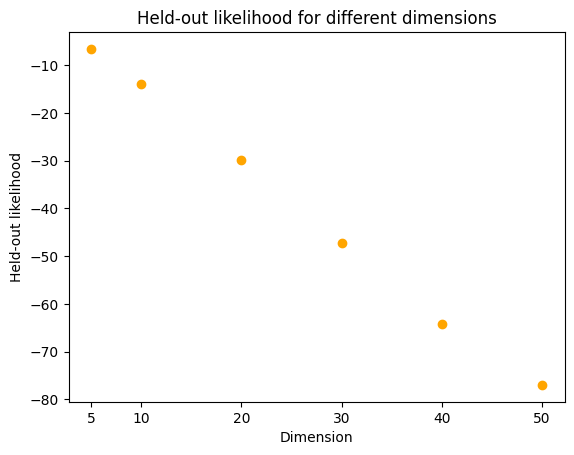

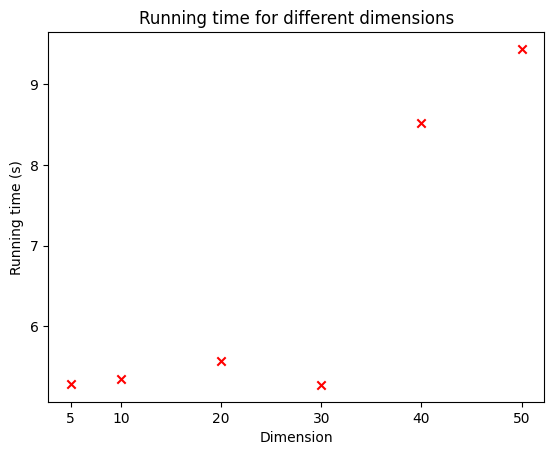

In [36]:
# plotting the held-out likelihood
plt.figure()
plt.scatter(dimension, held_outs, marker='o', color='orange')
plt.xlabel("Dimension")
plt.xticks(dimension)
plt.ylabel("Held-out likelihood")
plt.title("Held-out likelihood for different dimensions")
plt.show()

# plotting the running times
plt.figure()
plt.xticks(dimension)
plt.scatter(dimension, running_times, marker='x', color='red')
plt.xlabel("Dimension")
plt.ylabel("Running time (s)")
plt.title("Running time for different dimensions")
plt.show()

## 3.3. On the robot data

In [37]:
"""# loading the dataset
X_train, Y_train, X_test, Y_test = getRobotData()


# mean and variance of X_train
train_mean = torch.mean(X_train, dim=0)
train_var = torch.mean(torch.var(X_train, dim=0)) # relevant as mean of all the features are close

# adapting parameters wrt the paper notations
robot_lambda_1 = train_mean / train_var
robot_lambda_2 = 1 / train_var
robot_lmbda = torch.tensor(robot_lambda_1.tolist() + [lambda_2])


# training the model
robot_K = 20
robot_alpha = 0.1
n_iter = 30
model = VariationalInferenceDirichletProcessMixtureModel(X_train[:], robot_K, robot_alpha, robot_lmbda)
model.train(n_iter)
robot_elbo, robot_gamma_list, robot_tau_list, robot_phi_list = model.predict()"""

'# loading the dataset\nX_train, Y_train, X_test, Y_test = getRobotData()\n\n\n# mean and variance of X_train\ntrain_mean = torch.mean(X_train, dim=0)\ntrain_var = torch.mean(torch.var(X_train, dim=0)) # relevant as mean of all the features are close\n\n# adapting parameters wrt the paper notations\nrobot_lambda_1 = train_mean / train_var\nrobot_lambda_2 = 1 / train_var\nrobot_lmbda = torch.tensor(robot_lambda_1.tolist() + [lambda_2])\n\n\n# training the model\nrobot_K = 20\nrobot_alpha = 0.1\nn_iter = 30\nmodel = VariationalInferenceDirichletProcessMixtureModel(X_train[:], robot_K, robot_alpha, robot_lmbda)\nmodel.train(n_iter)\nrobot_elbo, robot_gamma_list, robot_tau_list, robot_phi_list = model.predict()'

In [38]:
"""# plotting the evolution of the ELBO
plt.figure()
plt.plot(robot_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.title("Evolution of the ELBO")
plt.show()
"""

'# plotting the evolution of the ELBO\nplt.figure()\nplt.plot(robot_elbo)\nplt.xlabel("Number of iterations")\nplt.ylabel("ELBO")\nplt.title("Evolution of the ELBO")\nplt.show()\n'